## Motivation

Given an asset’s price at a pair of times (e.g., the price of APPL at 9:00am and 9:30am on a particular trading day), one may be interested in interpolating the price between these times. Of course, while it is possible to simply interpolate linearly between these times, this approach does not generate a distribution of possible realizations which may be needed for statistical analyses.

Consider, for example, modeling the stock price as a geometric Brownian motion (GBM). As the name suggests, the noise from a GBM is generated by a Brownian motion (a.k.a. a Wiener process). Since the Brownian bridge describes a Brownian motion between a pair of times at which the value of the Brownian motion has already been realized, it is the appropriate tool to stochastically interpolate the GBM.

## Brownian bridge

As described above, a Brownian bridge $B$ is a Wiener process on the time horizon $[t,T]$ that is pinned on both sides.
That is, at time $t$ it is equal to a known value $B_t$ and at time $T$ it is equal to a known value $B_T$.
Let $B_s$ be the Brownian bridge at time $s$ in $(t,T)$.
It can be shown that $B_s$ is normal with mean
\begin{equation}
a+\frac{s-t}{T-t}\left(b-a\right)
\end{equation}
and variance
\begin{equation}
\frac{\left(T-s\right)\left(s-t\right)}{T-t}.
\end{equation}
Note that the uncertainty is maximized at exactly the middle of the interval $(t+T)/2$.

## Simulation

To simulate the bridge, pick a point $s$ in the interval $(t,T)$ and use the above distributional characterization to sample $B_s$.
Now, the values of $B$ on the mesh $\{t,s,T\}$ are known.

To further refine this mesh, pick a new point $r$ that is in either $(t,s)$ or $(s,T)$.
Depending on which interval is picked, a Brownian bridge with the endpoints $(B_t, B_s)$ or $(B_s, B_T)$ can be used to sample $B_r$.
This procedure can be repeated as many times as necessary to obtain as fine a mesh as desired.

## Application to Geometric Brownian motion

Consider now a geometric Brownian motion
\begin{equation}
dS_t = \mu S_t dt + \sigma S_t dW_t.
\end{equation}
Let $X_t = \log S_t$. By Ito's lemma,
\begin{equation}
dX_t = \left(\mu-\frac{1}{2}\sigma^{2}\right)dt + \sigma dW_t.
\end{equation}
If $X_t = a$ and $X_T = b$,
\begin{equation}
b-a=\left(\mu-\frac{1}{2}\sigma^{2}\right)\left(T-t\right)+\sigma\left(W_{T}-W_{t}\right)
\end{equation}
and hence
\begin{equation}
W_{T}-W_{t}=\frac{b-a-\left(\mu-\frac{1}{2}\sigma^{2}\right)\left(T-t\right)}{\sigma}.
\end{equation}
Therefore, simulating the process $X$ between the initial and final times is equivalent to simulating a Brownian bridge that is pinned at $B_t = 0$ and $B_T = W_T - W_t$ as given above.

## Interpolating the NASDAQ in 2017

*Remark*. Below, the price of a symbol on a particular trading day is defined to be the midpoint between its open and close price.

The price of the NASDAQ on the first and last trading days of 2017 was 5427.35 and 6928.00, respectively. In a previous article, the maximum likelihood estimators for the NASDAQ drift and volatility (assuming a GBM model) in 2017 were found to be 24.696% and 7.530% per annum, respectively. With only this information, the ideas from the previous section can be used to generate realizations which agree with the NASDAQ on the first and last trading days of 2017.

*Disclaimer*. The code below is optimized for readability, not speed.

In [10]:
%load_ext lab_black

In [17]:
import numpy as np


def sim_gbm_bridge(
    annual_drift: float,
    annual_vol: float,
    n_days: int,
    n_sims: int,
    price_start: float,
    price_end: float,
):
    """
    Parameters
    ----------
    annual_drift: GBM drift (annualized).
    annual_vol: GBM volatility (annualized).
    n_days: Number of days to simulate.
    n_sims: Number of independent simulations.
    price_start: Initial price.
    price_end: Final price.

    Returns
    -------
    A NumPy array of shape (n_days, n_sims).
    """
    n_trading_days_per_year = 250
    dt = 1.0 / n_trading_days_per_year
    x = np.empty([n_days, n_sims])
    x[0] = np.log(price_start)
    x[-1] = np.log(price_end)
    drift_in_logspace = annual_drift - 0.5 * annual_vol**2
    for n in range(1, n_days - 1):
        s = n * dt
        t = s - dt
        T = 1.0
        a = x[n - 1]
        b = x[-1]
        dw = (b - a - drift_in_logspace * (T - t)) / annual_vol
        mean = (s - t) / (T - t) * dw
        var = (T - s) * (s - t) / (T - t)
        samples = mean + np.sqrt(var) * np.random.randn(n_sims)
        x[n] = a + drift_in_logspace * dt + annual_vol * samples
    return np.exp(x)

In [24]:
np.random.seed(1)

In [29]:
import yfinance as yf

ticker = yf.Ticker("^IXIC")  # NASDAQ
df = ticker.history(start="2017-01-01", end="2017-12-31")
price = (df.Open + df.Close) / 2.0
sims = sim_gbm_bridge(
    annual_drift=0.24696,
    annual_vol=0.07530,
    n_days=251,
    n_sims=9,
    price_start=price[0],
    price_end=price[-1],
)

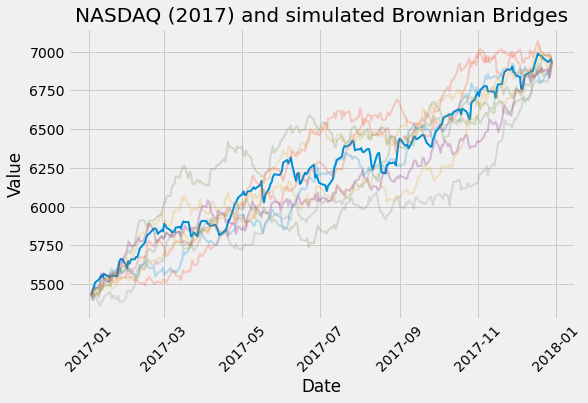

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("fivethirtyeight")
mpl.rcParams["lines.linewidth"] = 2
plt.figure(figsize=(1.618 * 5.0, 5.0))
plt.plot(price.index, price)
for sim in sims.T:
    plt.plot(price.index, sim, alpha=0.25)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Value")
_ = plt.title("NASDAQ (2017) and simulated Brownian Bridges")